# **Spotify Project**

## **Hypothesis:** I hypothesize one can predict a song's genre by using it's audio features. 
### Below is the link to the dataset on kaggle: https://www.kaggle.com/datasets/solomonameh/spotify-music-dataset/data?select=high_popularity_spotify_data.csv
### Project go-round 1:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## Understanding the data

In [3]:
#high_popularity_spotify_data = high spotify = hs
hs = pd.read_csv('D:\Datasets\high_popularity_spotify_data.csv')
hs.head()

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,time_signature,speechiness,track_popularity,instrumentalness,mode,key,duration_ms,acousticness
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,3,0.0304,100,0.0000,0,6,251668,0.3080
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,4,0.0358,97,0.0608,1,2,210373,0.2000
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,4,0.0368,93,0.0000,1,1,166300,0.2140
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,4,0.0634,81,0.0000,0,0,157280,0.0939
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,4,0.2600,98,0.0000,0,0,169917,0.0283


In [4]:
# I want to understand the data types of the columns and the number of NaN values in each column
hs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686 entries, 0 to 1685
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   energy            1686 non-null   float64
 1   tempo             1686 non-null   float64
 2   danceability      1686 non-null   float64
 3   playlist_genre    1686 non-null   object 
 4   loudness          1686 non-null   float64
 5   liveness          1686 non-null   float64
 6   valence           1686 non-null   float64
 7   time_signature    1686 non-null   int64  
 8   speechiness       1686 non-null   float64
 9   track_popularity  1686 non-null   int64  
 10  instrumentalness  1686 non-null   float64
 11  mode              1686 non-null   int64  
 12  key               1686 non-null   int64  
 13  duration_ms       1686 non-null   int64  
 14  acousticness      1686 non-null   float64
dtypes: float64(9), int64(5), object(1)
memory usage: 197.7+ KB


In [5]:
#Does the dataset have any missing values?
print(hs.isna().any().any())

False


In [6]:
na_columns = hs.isna().sum()
na_columns = na_columns[na_columns > 0]
print(na_columns)
#All good I'm gonna let it slide, on the other hand I did delete 8 columns that were not applicable to the analysis such as the url, and api columns in excel as csv file.

Series([], dtype: int64)


In [7]:
hs['playlist_genre'].value_counts()
# The dataset has an off balance of the genres, which will off course any predictions as the model will have more data of a genre(pop) to interpret and overlay onto another genre by accident. 
# To fix this problem I will need to either take away data from the larger genre's(CAUTION: could be throwing away useful information), add more data to the smaller genre's(A common technique 
# would be Bootstrapping) or create weights to balance the data.
# I will bootstrap in the second go around on this project.


playlist_genre
pop           357
rock          235
hip-hop       227
latin         184
electronic    148
gaming        100
ambient        61
r&b            50
arabic         50
punk           50
blues          45
metal          35
folk           33
afrobeats      20
brazilian      14
j-pop          11
k-pop          11
classical      10
indian          9
korean          8
turkish         7
reggae          5
indie           4
world           4
country         3
soul            2
lofi            2
jazz            1
Name: count, dtype: int64

### Data Preparation

In [8]:
hs_required = hs[['energy', 'tempo', 'danceability','playlist_genre', 'loudness',
       'liveness', 'valence','time_signature', 'speechiness',
       'track_popularity','instrumentalness', 'mode', 'key',
       'duration_ms', 'acousticness']]
hs_required.head()

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,time_signature,speechiness,track_popularity,instrumentalness,mode,key,duration_ms,acousticness
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,3,0.0304,100,0.0000,0,6,251668,0.3080
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,4,0.0358,97,0.0608,1,2,210373,0.2000
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,4,0.0368,93,0.0000,1,1,166300,0.2140
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,4,0.0634,81,0.0000,0,0,157280,0.0939
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,4,0.2600,98,0.0000,0,0,169917,0.0283


In [9]:
#Ran into error "could not convert string to float: 'hip-hop'"
hs_required['playlist_genre'].astype(object)
#Going to take out the dash between the playlist_genre for the genre hip-hop
#Realizing I need to encode the output column since it's an object data type

0         pop
1         pop
2         pop
3         pop
4         pop
        ...  
1681    latin
1682    latin
1683    latin
1684    latin
1685      pop
Name: playlist_genre, Length: 1686, dtype: object

In [10]:
hs_required['playlist_genre'].unique()

array(['pop', 'rock', 'jazz', 'classical', 'hip-hop', 'afrobeats',
       'latin', 'indian', 'country', 'r&b', 'electronic', 'soul',
       'gaming', 'j-pop', 'metal', 'reggae', 'k-pop', 'arabic', 'punk',
       'blues', 'folk', 'lofi', 'brazilian', 'turkish', 'ambient',
       'korean', 'world', 'indie'], dtype=object)

In [11]:
hs_new = hs_required

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
hs_required['playlist_genre'] = label_encoder.fit_transform(hs_required['playlist_genre'])

print(hs_required.head())

   energy    tempo  danceability  playlist_genre  loudness  liveness  valence  \
0   0.592  157.969         0.521              20    -7.777     0.122    0.535   
1   0.507  104.978         0.747              20   -10.171     0.117    0.438   
2   0.808  108.548         0.554              20    -4.169     0.159    0.372   
3   0.910  112.966         0.670              20    -4.070     0.304    0.786   
4   0.783  149.027         0.777              20    -4.477     0.355    0.939   

   time_signature  speechiness  track_popularity  instrumentalness  mode  key  \
0               3       0.0304               100            0.0000     0    6   
1               4       0.0358                97            0.0608     1    2   
2               4       0.0368                93            0.0000     1    1   
3               4       0.0634                81            0.0000     0    0   
4               4       0.2600                98            0.0000     0    0   

   duration_ms  acousticne

In [13]:
#Visual table of the encoded values
encoded_values = pd.DataFrame({
    'Encoded Value': range(len(label_encoder.classes_)),
    'Actual Value': label_encoder.classes_
})
print(encoded_values)

    Encoded Value Actual Value
0               0    afrobeats
1               1      ambient
2               2       arabic
3               3        blues
4               4    brazilian
5               5    classical
6               6      country
7               7   electronic
8               8         folk
9               9       gaming
10             10      hip-hop
11             11       indian
12             12        indie
13             13        j-pop
14             14         jazz
15             15        k-pop
16             16       korean
17             17        latin
18             18         lofi
19             19        metal
20             20          pop
21             21         punk
22             22          r&b
23             23       reggae
24             24         rock
25             25         soul
26             26      turkish
27             27        world


## Data Preparation

### Data Splitting

In [14]:
y = hs_required['playlist_genre']
X = hs_required.drop('playlist_genre', axis=1)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)


In [16]:
y_test.head()

331     24
1575    16
203     10
631     24
518      9
Name: playlist_genre, dtype: int64

## Model Building

### Linear Regression

#### Training the Model

In [17]:
from sklearn.linear_model import LinearRegression
# Fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)

#### Applying the model to make predictions

In [18]:
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)


In [19]:
print(y_lr_train_pred)

[13.90745372 15.43275744 12.02925029 ... 16.24871295  7.41813137
 18.54715135]


#### Evaluate Model Performance (Linear Regression )

In [20]:
y_train

366     22
1204     3
226     10
231     10
1061    24
        ..
1130    21
1294     7
860     20
1459    10
1126    19
Name: playlist_genre, Length: 1348, dtype: int64

In [21]:
y_lr_train_pred

array([13.90745372, 15.43275744, 12.02925029, ..., 16.24871295,
        7.41813137, 18.54715135], shape=(1348,))

In [22]:
# Calculate the mean square error (mse) and r2 score
from sklearn.metrics import mean_squared_error, r2_score

lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)

lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)

print(f"Train MSE: {lr_train_mse}, Train R2: {lr_train_r2}")
print(f"Test MSE: {lr_test_mse}, Test R2: {lr_test_r2}")

#Not great results as we would want to see lower MSE's and higher R^2.

Train MSE: 40.28608652981243, Train R2: 0.2487153944351631
Test MSE: 39.763209776347054, Test R2: 0.2484048236733455


In [23]:
lr_results = pd.DataFrame(['Linear Regression', lr_train_mse, lr_train_r2, lr_test_mse, lr_test_r2]).transpose()
lr_results.columns = ['Method', 'Train MSE', 'Train R2', 'Test MSE', 'Test R2']

### Random Forest

#### Training RF Regressor

In [24]:
from sklearn.ensemble import RandomForestRegressor
#Since we are working with categorical data we use a classification model,
# but if it's a quantitative value we use a regression model

In [25]:
rf = RandomForestRegressor(max_depth=2, random_state=100)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, random_state=100)

##### RF Regressor Predictions

In [26]:
y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

###### **RF Regressor Evaluation**

In [27]:
# Calculate the mean square error (mse) and r2 score
from sklearn.metrics import mean_squared_error, r2_score

rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_train_r2 = r2_score(y_train, y_rf_train_pred)

rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)

print(f"Train MSE: {rf_train_mse}, Train R2: {rf_train_r2}")
print(f"Test MSE: {rf_test_mse}, Test R2: {rf_test_r2}")

Train MSE: 43.66270681032451, Train R2: 0.18574569312874634
Test MSE: 45.581053993573896, Test R2: 0.13843725126452355


In [28]:
rf_results = pd.DataFrame(['Random Forest Regressor', rf_train_mse, rf_train_r2, rf_test_mse, rf_test_r2]).transpose()
rf_results.columns = ['Method', 'Train MSE', 'Train R2', 'Test MSE', 'Test R2']

#### Training RF Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
rfc = RandomForestClassifier(max_depth=2, random_state=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=100)

##### RF Classifier makes predictions

In [31]:
y_rfc_train_pred = rfc.predict(X_train)
y_rfc_test_pred = rfc.predict(X_test)

###### **RF Classifier Evaluation** ######

In [32]:
# Calculate the mean square error (mse) and r2 score
from sklearn.metrics import mean_squared_error, r2_score

rfc_train_mse = mean_squared_error(y_train, y_rfc_train_pred)
rfc_train_r2 = r2_score(y_train, y_rfc_train_pred)

rfc_test_mse = mean_squared_error(y_test, y_rfc_test_pred)
rfc_test_r2 = r2_score(y_test, y_rfc_test_pred)

print(f"Train MSE: {rfc_train_mse}, Train R2: {rfc_train_r2}")
print(f"Test MSE: {rfc_test_mse}, Test R2: {rfc_test_r2}")

Train MSE: 65.79673590504451, Train R2: -0.22702597943571612
Test MSE: 70.83136094674556, Test R2: -0.338838326172894


In [33]:
rfc_results = pd.DataFrame(['Random Forest Classifier', rfc_train_mse, rfc_train_r2, rfc_test_mse, rfc_test_r2]).transpose()
rfc_results.columns = ['Method', 'Train MSE', 'Train R2', 'Test MSE', 'Test R2']

### Model Comparison

In [34]:
comparison = pd.concat([lr_results, rf_results, rfc_results], axis=0)
comparison.reset_index(drop=True, inplace=True)
comparison

,Method,Train MSE,Train R2,Test MSE,Test R2
0,Linear Regression,40.286087,0.248715,39.76321,0.248405
1,Random Forest Regressor,43.662707,0.185746,45.581054,0.138437
2,Random Forest Classifier,65.796736,-0.227026,70.831361,-0.338838


What story is my data telling me? 
Let's look at the MSE(Mean Squared Error) values. MSE values have a lower bound of 0, but no upper bound. It's better to have a lower MSE value since we're essentially measuring the distance between the predicted value and the real values. The R2 measures the proportion of the variance in the dependent variable that is predictable from the independent variables. The R2 values are bounded between 0 to 1, where 1 indicates that the model perfectly predicts the dependent. 


**From this first set of tests it looks like the LR has the best results for the MSE and R2.**

## Data visualization of prediction results

### Linear Regression Visualization

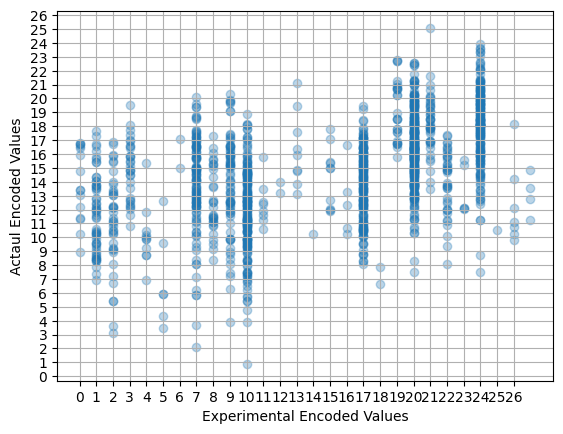

In [35]:
plt.scatter(x=y_train, y=y_lr_train_pred, alpha = 0.3)

plt.plot()
plt.ylabel('Actaul Encoded Values')
plt.xlabel('Experimental Encoded Values')
#how to make the x and y axis display a tick mark for each 1 value
plt.yticks(range(0, 27))
plt.xticks(range(0, 27))
plt.grid()

### Random Forest Regressor

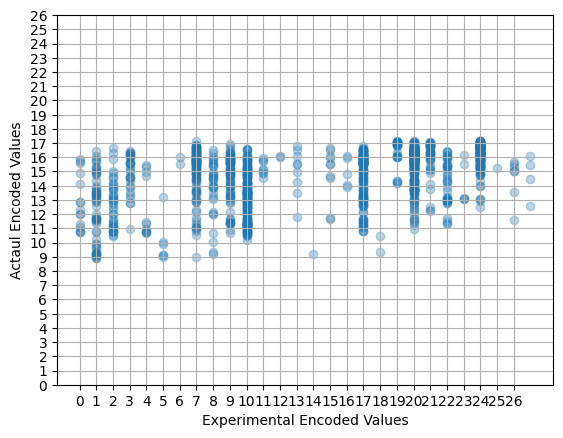

In [36]:
plt.scatter(x=y_train, y=y_rf_train_pred, alpha = 0.3)

plt.plot()
plt.ylabel('Actaul Encoded Values')
plt.xlabel('Experimental Encoded Values')
#how to make the x and y axis display a tick mark for each 1 value
plt.yticks(range(0, 27))
plt.xticks(range(0, 27))
plt.grid()

### Random Forest Classifier

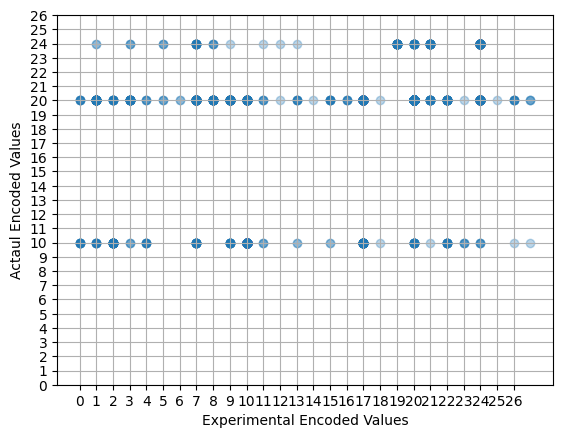

In [37]:
plt.scatter(x=y_train, y=y_rfc_train_pred, alpha = 0.3)

plt.plot()
plt.ylabel('Actaul Encoded Values')
plt.xlabel('Experimental Encoded Values')
#how to make the x and y axis display a tick mark for each 1 value
plt.yticks(range(0, 27))
plt.xticks(range(0, 27))
plt.grid()

## Re-Planning / Project Re-evaluation after the Project go-round 1

### 1. Why are the current models not accurate?
#### The output column is a categorical value. Sheds light on other models that are more stuitable for categorical outputs.

### 2. What are other models that are great to fit categorical output?

###### According to chatgpt the top models are: Logistic Regression, Decision Trees(Classifier), Random Forest (Classifier), Gradient Boosting Machines(GBM), Support Vector Machines (SVM), K-Nearest Neighbors(k-NN), Naive Bayes, and Neural Networks.

###### Here are other models that work with categorical outputs:
###### K-Nearest Neighbors, Support Vector Machine, Decision Trees, Gradient Boosting, AdaBoost, XGBoost, LightGBM, CatBoost, Neural Networks, Logistic Regression, Naive Bayes, Random Forest Classifier, Extra Trees Classifier, Bagging Classifier, Stacking Classifier, Voting Classifier, Gaussian Process Classifier, Quadratic Discriminant Analysis, Linear Discriminant Analysis, Ridge Classifier, Perceptron, Passive Aggressive Classifier, SGD Classifier, Nearest Centroid 

Tasks after Project go-round 1:

- This dataset(high-popularity spotify -> hs_required) has an unbalanced number of genres. This can be easily explained as the majority of spotify users listen to Pop and this dataset is linked to high-popularity of songs with audio features and what genre they belong to. My hypothesis is that the dataset that focuses on non popular songs will have a more balanced dataset. In short, I will need to revisit the data preparation section to balance the data.

Lessons Learned in Project go-round 1:
- The difference between categorical and numerical data
    - Models that run well with categorical data
- Unbalanced data
    - Undersampling, oversampling, up/down weighting
- Metrics for modeling
- Outside influences to skew data
    - i.e. popularity with pop genre





## Project go-round 2

Creating more samples to even out the genre results for a balanced test. Also, transforming the data and focusing on models that perform effectively with categorical output data.

### Data Preparation

In [38]:
# I want an equal number of songs in the other genres to be as much as the pop genre.

m = len(hs_new)

m

1686

In [39]:
hs_testing_bootstrap = hs_new

In [ ]:
def boostrap_sample(hs_new, n_samples = 1):
    samples = []
    n = len(hs_new)
    for _ in range(1000):
        sample_indices = np.random.choice(hs_new.index, size=n, replace=True)
        sample = hs_new.loc[sample_indices]
        samples.append(sample)
    return samples

# Generate bootstrap samples
bootstrap_samples = boostrap_sample(hs_new, 1000)

#for i, sample in enumerate(bootstrap_samples):
#    print(f"Bootstrap Sample {i+1}:\n{sample}\n")

bootstrap_samples_df = pd.concat(bootstrap_samples, ignore_index=True)
#Combining the samples together to create a large df

Bootstrap Sample 1:
      energy    tempo  danceability  playlist_genre  loudness  liveness  \
573    0.571  101.955         0.695              13    -6.249    0.1180   
1350   0.791   92.023         0.860              17    -4.784    0.1060   
531    0.777  108.005         0.580               9    -5.690    0.3420   
20     0.812   80.090         0.505              20    -3.986    0.4440   
453    0.604  159.920         0.561              25    -4.409    0.1040   
...      ...      ...           ...             ...       ...       ...   
135    0.978  141.167         0.526              24    -5.436    0.0744   
874    0.719  112.027         0.558              20    -5.113    0.1150   
834    0.417  138.178         0.209              20    -8.740    0.1130   
1323   0.778   96.057         0.911              17    -2.248    0.1790   
1327   0.795   94.969         0.845              17    -3.502    0.2240   

      valence  time_signature  speechiness  track_popularity  \
573     0.726  

In [ ]:
#Combining the new samples with the current dataset we're using
df_combined = pd.concat([hs_testing_bootstrap, bootstrap_samples_df], ignore_index = True)
#print(df_combined) 
df_combined['playlist_genre'].value_counts()

         energy    tempo  danceability  playlist_genre  loudness  liveness  \
0         0.592  157.969         0.521              20    -7.777     0.122   
1         0.507  104.978         0.747              20   -10.171     0.117   
2         0.808  108.548         0.554              20    -4.169     0.159   
3         0.910  112.966         0.670              20    -4.070     0.304   
4         0.783  149.027         0.777              20    -4.477     0.355   
...         ...      ...           ...             ...       ...       ...   
1687681   0.573  107.363         0.684              20   -12.300     0.306   
1687682   0.612   86.768         0.536              22    -5.847     0.209   
1687683   0.551  148.035         0.527               8   -11.258     0.403   
1687684   0.159   72.380         0.403               1   -16.728     0.340   
1687685   0.944  105.338         0.394              24    -6.506     0.298   

         valence  time_signature  speechiness  track_popularity

playlist_genre
20    356703
24    235099
10    227751
17    184669
7     147891
9     100267
1      61406
21     50004
22     49926
2      49802
3      44925
19     34893
8      33347
0      19890
4      14016
13     11039
15     10931
5      10160
11      8994
16      8081
26      6986
23      4925
12      4056
27      3943
6       2904
18      2045
25      2028
14      1005
Name: count, dtype: int64

In [ ]:
#Since there are over a 1000 songs in each genre, there is enough data to test from
genre_sample = pd.DataFrame()
sampling_boot_combined = pd.DataFrame()

def sampling_boot(df_combined, encoded_values, n_samples=516):
    samples = []
    for i in encoded_values['Encoded Value']:
        genre_sample = df_combined[df_combined['playlist_genre'] == i]
        if len(genre_sample) >= n_samples:
            genre_sample = genre_sample.sample(n_samples)
        else:
            genre_sample = genre_sample.sample(n_samples, replace=True)
        samples.append(genre_sample)
    return pd.concat(samples, ignore_index=True)

sampling_boot_combined = sampling_boot(df_combined, encoded_values)
#print(sampling_boot_combined)
#Evening out the samples in the oversized categories(genres)
#Now I will use the new dataset to test the models

       energy    tempo  danceability  playlist_genre  loudness  liveness  \
0       0.819  110.140         0.726               0    -7.094    0.2700   
1       0.814   93.482         0.683               0    -3.505    0.0858   
2       0.705  197.980         0.374               0    -8.370    0.1400   
3       0.814   93.482         0.683               0    -3.505    0.0858   
4       0.520   95.865         0.578               0    -8.399    0.1240   
...       ...      ...           ...             ...       ...       ...   
14443   0.588   79.989         0.675              27    -7.168    0.9500   
14444   0.588   79.989         0.675              27    -7.168    0.9500   
14445   0.588   79.989         0.675              27    -7.168    0.9500   
14446   0.321  110.827         0.680              27   -10.944    0.1250   
14447   0.588   79.989         0.675              27    -7.168    0.9500   

       valence  time_signature  speechiness  track_popularity  \
0        0.636        

In [43]:
b = sampling_boot_combined['playlist_genre']
A = sampling_boot_combined.drop('playlist_genre', axis=1)

In [44]:
from sklearn.model_selection import train_test_split

A_train, A_test, b_train, b_test = train_test_split(A,b,test_size=0.2, random_state=42)

### K-Nearst Neighbors

#### KNN Building 

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(A_train, b_train)
knn.predict(A_test)

knn_accuracy = accuracy_score(b_test, knn.predict(A_test))
print(knn_accuracy)


0.8775086505190312


In [46]:
from sklearn.metrics import confusion_matrix
knn_cm = confusion_matrix(b_test,knn.predict(A_test))


Text(58.222222222222214, 0.5, 'Truth')

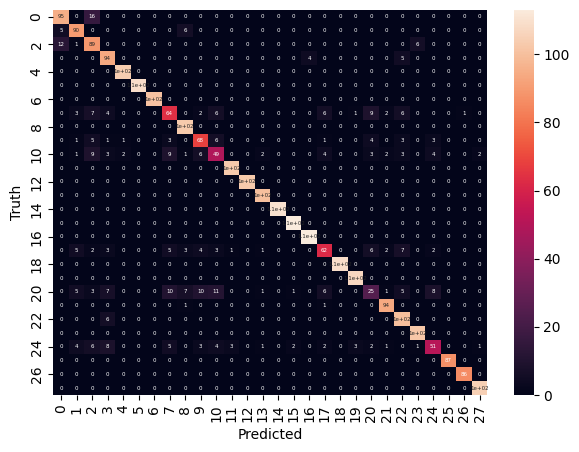

In [47]:
plt.figure(figsize=(7,5))
sns.heatmap(knn_cm, annot=True, annot_kws={"size": 4})

plt.xlabel('Predicted')
plt.ylabel('Truth')

In [48]:
# Import necessary libraries
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions 
from sklearn.decomposition import PCA

#Convert DataFrame to NumPy arrays
A_np = A.values
b_np = b.values

# Reduce the dimensionality of A_np to 2D using PCA
pca = PCA(n_components = 2)
A_pca = pca.fit_transform(A_np)

# Train the KNN model on the reduced 2D data
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(A_pca, b_np)
knn.predict(A_pca)

knn_accuracy = accuracy_score(b_np, knn.predict(A_pca))
print(knn_accuracy)


0.9337624584717608


In [49]:
from sklearn.metrics import confusion_matrix
knn_cm2 = confusion_matrix(b_np,knn.predict(A_pca))


Text(58.222222222222214, 0.5, 'Truth')

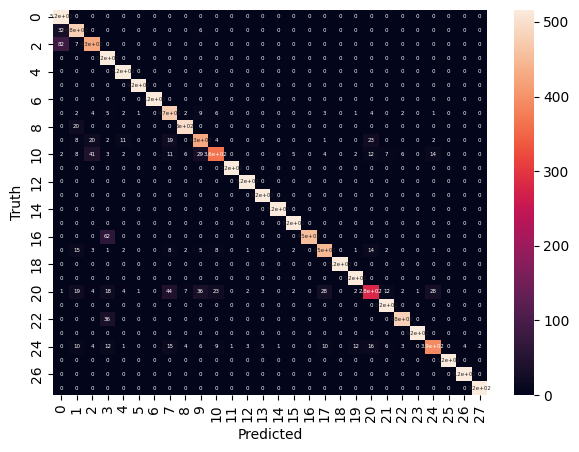

In [50]:
plt.figure(figsize=(7,5))
sns.heatmap(knn_cm2, annot=True, annot_kws={"size": 4})

plt.xlabel('Predicted')
plt.ylabel('Truth')

### Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression

#A_LogR = pd.get_dummies(A, predix='', prefix_sep='', drop_first=True)

logit_reg = LogisticRegression(penalty= 'l2', C=1e42, solver='liblinear')
logit_reg.fit(A_train,b_train)

LogisticRegression(C=1e+42, solver='liblinear')

In [52]:
b_pred_logreg = logit_reg.predict(A_test)

accuracy_log_reg=accuracy_score(b_test, b_pred_logreg)
print("Logistic Regression Accuracy:", accuracy_log_reg)

Logistic Regression Accuracy: 0.18788927335640138


### Naive Bayes ( Multinomial )

In [53]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB

# Scale the data to be between 0 and 1
scaler = MinMaxScaler()
A_train_scaled = scaler.fit_transform(A_train)
A_test_scaled = scaler.transform(A_test)

multinomialNB_model = MultinomialNB(alpha=0.01, fit_prior=True)
multinomialNB_model.fit(A_train_scaled, b_train)

MultinomialNB(alpha=0.01)

In [54]:
b_pred_multinomialNB = multinomialNB_model.predict(A_test_scaled)

accuracy_multinomialNB = accuracy_score(b_test, b_pred_multinomialNB)
print("Naive Bayes Accuracy: ", accuracy_multinomialNB)

Naive Bayes Accuracy:  0.34705882352941175


### Naive Bayes ( Gaussian )

In [55]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB

gaussianNB_model = GaussianNB()
gaussianNB_model.fit(A_train_scaled, b_train)

GaussianNB()

In [56]:
b_pred_gaussianNB = gaussianNB_model.predict(A_test_scaled)
accuracy_gaussianNB = accuracy_score(b_test, b_pred_gaussianNB)
print("Gaussian Accuracy Score:", accuracy_gaussianNB)

Gaussian Accuracy Score: 0.4799307958477509


### Random Forest Classifier (part 2)

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
rfc = RandomForestClassifier(max_depth=2, random_state=100)
rfc.fit(A_train, b_train)

RandomForestClassifier(max_depth=2, random_state=100)

In [59]:
b_rfc_train_pred = rfc.predict(A_train)
b_rfc_test_pred = rfc.predict(A_test)


In [60]:
accuracy_rfclass = accuracy_score(b_test, b_rfc_test_pred)
print("Accuracy Score for RF Classifier:", accuracy_rfclass)

Accuracy Score for RF Classifier: 0.4076124567474048


### Random Forest Regressor (part 2)

In [61]:
from sklearn.ensemble import RandomForestRegressor

In [62]:
rfReg = RandomForestRegressor(max_depth=2, random_state=100)
rfReg.fit(A_train, b_train)

RandomForestRegressor(max_depth=2, random_state=100)

In [63]:
b_rfReg_train_pred = rfReg.predict(A_train)
b_rfReg_test_pred = rfReg.predict(A_test)

In [64]:
from sklearn.metrics import mean_squared_error, r2_score

rfReg_test_mse = mean_squared_error(b_test, b_rfReg_test_pred)
rfReg_test_r2 = r2_score(b_test, b_rfReg_test_pred)


print(f"Test MSE: {rfReg_test_mse}, Test R2: {rfReg_test_r2}")


Test MSE: 53.70786152396515, Test R2: 0.1625537529203549


## Conclusion

Many of the models that were performed indicated the difficulty to predict a genre by it's audio features. As you can see many of the models performed with an MSE or accuracy score in the neighborhood of 50 (.50) or less. On the other hand one model stuck out with was the KNN. While the table had 27 variables the KNN model was able to have an accuracy score of 0.87 then after a principal component analysis(pca) I was able to increase the accuracy to 0.93.

**Disclosure/Sources:** Although I created this project, not every line of program was coded by me, I used AI tools such as ChatGPT and Co-Pilot to help with coding syntax. I also surfed the web of example models and studied topics from an O-Reily textbook ("Practical Statistics for Data Scientists: 50 Essential Concepts"). 